# Import Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Scrape NYT article for Stay at Home data

## Initialize Beautiful Soup Object

In [2]:
# Get URL
URL = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html'
page = requests.get(URL)

In [3]:
# Initialize Soup Object
soup = BeautifulSoup(page.content, 'html.parser')

## Parse HTML & Format Results

In [4]:
# Dig into list-wrap element of html
results = soup.find('div', class_= 'list-wrap')

In [5]:
# Each state is divided by this header
state_orders = results.find_all('div', class_='state-wrap statewide')

In [6]:
# Pull the specific elements where the data is that we need & extract the info
State = []
population_elem = []
order_date_elem = []

for state_orders in state_orders:
    State.append(state_orders['data-state'])
    population_elem.append(state_orders.find('span', class_='l-population').text)
    order_date_elem.append(state_orders.find('span', class_='l-date').text)

In [7]:
# Format the population data into a list
Population = []

for population_elem in population_elem:
    text = population_elem.split()
    if text[2] == 'million':
        Population.append(int(float(text[1]) * 1000000))
    else:
        Population.append(int(text[1].replace(',', '')))

In [8]:
# Format the date information into a list
SAH_Month = []
SAH_Day = []

for order_date_elem in order_date_elem:
    text = order_date_elem.split()
    SAH_Month.append(text[2])
    SAH_Day.append(text[3])

# Reformat Month to number
for i in range(len(SAH_Month)):
    datetime_object = datetime.datetime.strptime(SAH_Month[i], "%B")
    month_number = datetime_object.month
    SAH_Month[i] = month_number

In [9]:
# Create the Year list to match the others
SAH_Year = []
for i in range(len(SAH_Month)):
    SAH_Year.append(2020)

In [10]:
# Create date column
date = pd.DataFrame({'year' : SAH_Year,
                     'month' : SAH_Month,
                     'day' : SAH_Day})
Date = pd.to_datetime(date[['month', 'day', 'year']])

In [11]:
# Create data frame
dict = {'state' : State, 
        'SAH_Order_Date' : Date,
        'Population' : Population
       }
SAH_data = pd.DataFrame(dict)
SAH_data

,state,SAH_Order_Date,Population
0,AL,2020-04-04,4900000
1,AK,2020-03-28,737000
2,AZ,2020-03-31,7200000
3,CA,2020-03-19,39600000
4,CO,2020-03-26,5700000
5,CT,2020-03-23,3600000
6,DE,2020-03-24,973000
7,DC,2020-04-01,702000
8,FL,2020-04-03,21500000
9,GA,2020-04-03,10600000


# Import COVID data

In [12]:
import fbprophet
import os
import math
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import fbprophet

os.getcwd()

Importing plotly failed. Interactive plots will not work.


'C:\\Users\\camco\\Python Class\\py4ds'

In [13]:
states = pd.read_csv('C:/Users/camco/Downloads/us_states_covid19_daily.csv')
states.shape

(2228, 25)

In [14]:
states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200414,AK,285.0,8063.0,NaN,NaN,32.0,NaN,NaN,NaN,...,32.0,8348.0,8348.0,8348.0,2,1.0,0.0,510.0,8.0,518.0
1,20200414,AL,3876.0,29241.0,NaN,NaN,493.0,NaN,210.0,NaN,...,493.0,33117.0,33117.0,33117.0,1,11.0,36.0,3793.0,142.0,3935.0
2,20200414,AR,1480.0,19651.0,NaN,81.0,130.0,NaN,43.0,29.0,...,130.0,21131.0,21131.0,21131.0,5,0.0,0.0,257.0,70.0,327.0
3,20200414,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200414,AZ,3806.0,40290.0,NaN,580.0,NaN,286.0,NaN,216.0,...,NaN,44096.0,44096.0,44096.0,4,9.0,0.0,645.0,104.0,749.0


In [15]:
# Replace NA's with 0's
states.isna().sum()
states = states.fillna(value = 0)
states.isna().sum()

date                        0
state                       0
positive                    0
negative                    0
pending                     0
hospitalizedCurrently       0
hospitalizedCumulative      0
inIcuCurrently              0
inIcuCumulative             0
onVentilatorCurrently       0
onVentilatorCumulative      0
recovered                   0
hash                        0
dateChecked                 0
death                       0
hospitalized                0
total                       0
totalTestResults            0
posNeg                      0
fips                        0
deathIncrease               0
hospitalizedIncrease        0
negativeIncrease            0
positiveIncrease            0
totalTestResultsIncrease    0
dtype: int64

In [16]:
# Change date string to date
states['date'] = pd.to_datetime(states['date'], format = '%Y%m%d')

In [17]:
# Reduce to columns used in analysis
states_analysis = states[['date', 'state', 'death', 'hospitalized']]
states_analysis.head()

,date,state,death,hospitalized
0,2020-04-14,AK,9.0,32.0
1,2020-04-14,AL,110.0,493.0
2,2020-04-14,AR,30.0,130.0
3,2020-04-14,AS,0.0,0.0
4,2020-04-14,AZ,131.0,0.0


In [18]:
# Join datasets
data = pd.merge(states_analysis, SAH_data, on='state')
data.shape

(1792, 6)

This join reduces the number of observations from 2228 to 1792, because not all states in the COVID dataset are in the New York Times article. I decided that this was ok since I need the stay-at-home order dates for each state in order to do my analysis.

In [19]:
data.head()

,date,state,death,hospitalized,SAH_Order_Date,Population
0,2020-04-14,AK,9.0,32.0,2020-03-28,737000
1,2020-04-13,AK,8.0,32.0,2020-03-28,737000
2,2020-04-12,AK,8.0,31.0,2020-03-28,737000
3,2020-04-11,AK,8.0,31.0,2020-03-28,737000
4,2020-04-10,AK,7.0,28.0,2020-03-28,737000


In [20]:
# Define function
row1 = data.loc[0]
def after_SAH(row):
    if row['date'] > row['SAH_Order_Date']:
        y = 1
    else:
        y = 0
    return y
after_SAH(row1)

1

In [21]:
data.state.unique()

array(['AK', 'AL', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OR',
       'PA', 'PR', 'RI', 'SC', 'TN', 'TX', 'VA', 'VT', 'WA', 'WI', 'WV'],
      dtype=object)

In [22]:
data['after_SAH_Order'] = data.apply(after_SAH, axis = 1)
data.head()

,date,state,death,hospitalized,SAH_Order_Date,Population,after_SAH_Order
0,2020-04-14,AK,9.0,32.0,2020-03-28,737000,1
1,2020-04-13,AK,8.0,32.0,2020-03-28,737000,1
2,2020-04-12,AK,8.0,31.0,2020-03-28,737000,1
3,2020-04-11,AK,8.0,31.0,2020-03-28,737000,1
4,2020-04-10,AK,7.0,28.0,2020-03-28,737000,1


In [23]:
# Divide data into before and after the stay at home orders in each state
before_SAH_data = data.loc[data['after_SAH_Order'] == 1]
after_SAH_data = data.loc[data['after_SAH_Order'] == 0]
after_SAH_data.shape

(1015, 7)

There are 777 observations before the stay-at-home orders, and 1015 afterwards.

# Plot Deaths before SAH Order

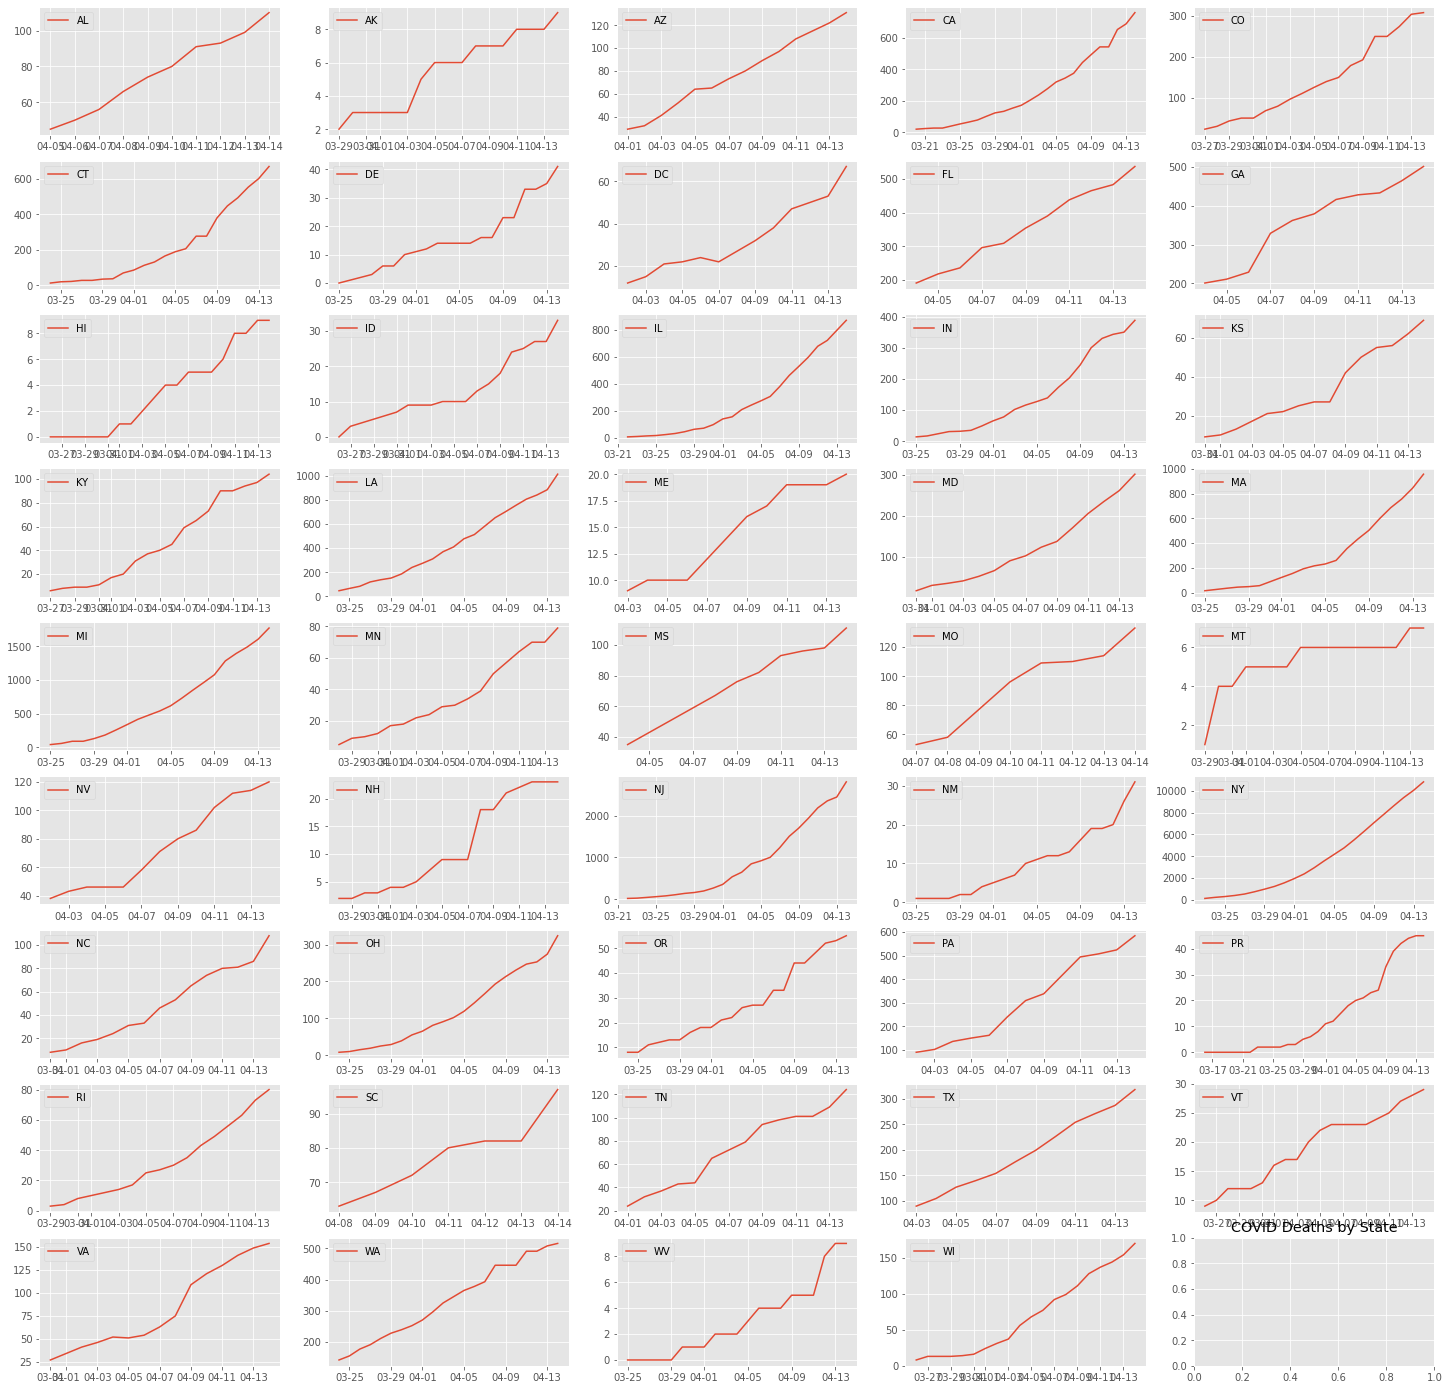

In [24]:
# Plot parameters
index = 0
max_death = max(data['death'])
states_used = []
plt.style.use('ggplot')
fig_rows = math.ceil((len(SAH_data) / 5))
myFmt = mdates.DateFormatter('%m-%d')

# Plots
fig, ax = plt.subplots(fig_rows, 5, figsize = (25, 25))
for i in range(fig_rows):
    for j in range(5):
        name = SAH_data['state'][index]
        plot_data = before_SAH_data.loc[data['state'] == name]
        ax[i, j].plot(plot_data['date'], plot_data['death'], label = name)
        ax[i, j].xaxis.set_major_formatter(myFmt)
        ax[i, j].legend()
        states_used.append(name)
        #ax[i, j].text(0.5, 0.5, name, fontsize=18, ha='center')
        if index == (len(SAH_data)-1):
            break
        else:
            index = index + 1
plt.title('COVID Deaths by State')
plt.show();

# Run Neural Network Model for each State

In [25]:
after_SAH_data.loc[after_SAH_data['state'] == 'AL']

,date,state,death,hospitalized,SAH_Order_Date,Population,after_SAH_Order
50,2020-04-04,AL,43.0,212.0,2020-04-04,4900000,0
51,2020-04-03,AL,35.0,0.0,2020-04-04,4900000,0
52,2020-04-02,AL,32.0,0.0,2020-04-04,4900000,0
53,2020-04-01,AL,26.0,0.0,2020-04-04,4900000,0
54,2020-03-31,AL,13.0,0.0,2020-04-04,4900000,0
55,2020-03-30,AL,6.0,0.0,2020-04-04,4900000,0
56,2020-03-29,AL,4.0,0.0,2020-04-04,4900000,0
57,2020-03-28,AL,3.0,0.0,2020-04-04,4900000,0
58,2020-03-27,AL,3.0,0.0,2020-04-04,4900000,0
59,2020-03-26,AL,1.0,0.0,2020-04-04,4900000,0


In [27]:
predictions = []

for i in range(len(SAH_data)):
    name = SAH_data['state'][i]
    before = before_SAH_data.loc[before_SAH_data['state'] == name]
    after = after_SAH_data.loc[after_SAH_data['state'] == name]

    # Shrink dataset to the 2 columns I need
    model_data = before[['date', 'death']]
    pred_data = after[['date', 'death']]

    # Prophet requires columns ds (Date) and y (value)
    model_data = model_data.rename(columns={'date': 'ds', 'death': 'y'})
    pred_data = pred_data.rename(columns={'date': 'ds', 'death': 'y'})

    # Make the prophet model and fit on the data
    prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.15)
    prophet_model.fit(model_data)
    predictions.append(prophet_model.predict(pred_data))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chan

ValueError: Dataframe has no rows.

In [31]:
predictions[5]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-07,-7.131703,-8.852800,7.331587,-7.131703,-7.131703,6.307224,6.307224,6.307224,6.307224,6.307224,6.307224,0.0,0.0,0.0,-0.824479
1,2020-03-08,-5.843751,-16.226168,0.105618,-5.843751,-5.843751,-1.741615,-1.741615,-1.741615,-1.741615,-1.741615,-1.741615,0.0,0.0,0.0,-7.585366
2,2020-03-09,-4.555799,-30.460756,-14.887441,-4.555799,-4.555799,-17.810412,-17.810412,-17.810412,-17.810412,-17.810412,-17.810412,0.0,0.0,0.0,-22.366210
3,2020-03-10,-3.267846,-11.916224,4.898879,-3.267846,-3.267846,0.093610,0.093610,0.093610,0.093610,0.093610,0.093610,0.0,0.0,0.0,-3.174237
4,2020-03-11,-1.979894,-18.198183,-2.467728,-1.979894,-1.979894,-8.412867,-8.412867,-8.412867,-8.412867,-8.412867,-8.412867,0.0,0.0,0.0,-10.392762
5,2020-03-12,-0.691942,-0.046808,16.003836,-0.691942,-0.691942,8.717905,8.717905,8.717905,8.717905,8.717905,8.717905,0.0,0.0,0.0,8.025963
6,2020-03-13,0.596010,5.440002,21.333751,0.596010,0.596010,12.846155,12.846155,12.846155,12.846155,12.846155,12.846155,0.0,0.0,0.0,13.442165
7,2020-03-14,1.883962,0.140342,16.148451,1.883962,1.883962,6.307224,6.307224,6.307224,6.307224,6.307224,6.307224,0.0,0.0,0.0,8.191187
8,2020-03-15,3.171914,-6.394293,9.832355,3.171914,3.171914,-1.741615,-1.741615,-1.741615,-1.741615,-1.741615,-1.741615,0.0,0.0,0.0,1.430300
9,2020-03-16,4.459867,-21.630063,-4.956645,4.459867,4.459867,-17.810412,-17.810412,-17.810412,-17.810412,-17.810412,-17.810412,0.0,0.0,0.0,-13.350545


C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

IndexError: list index out of range

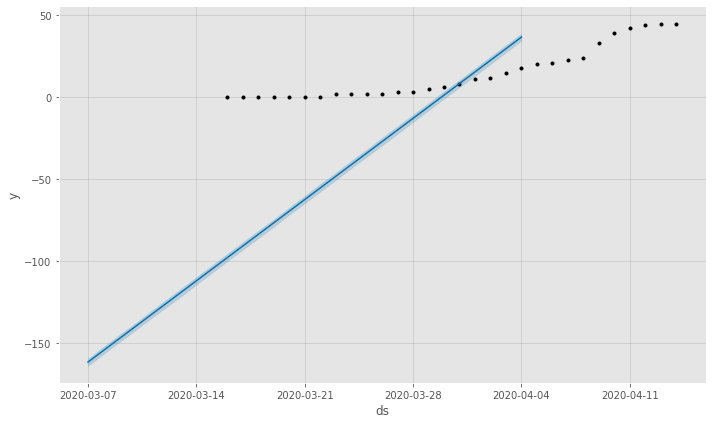

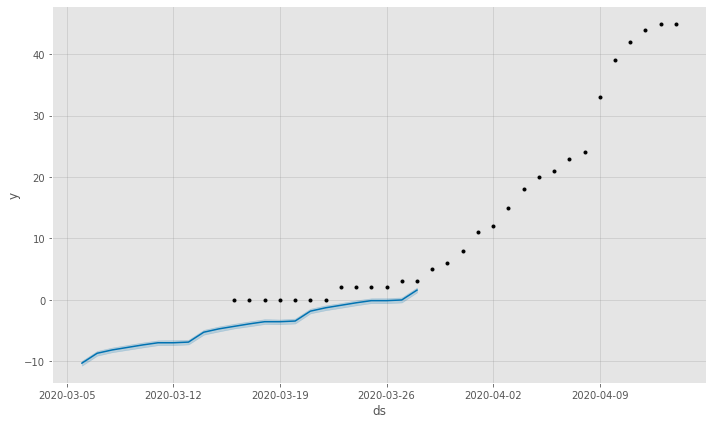

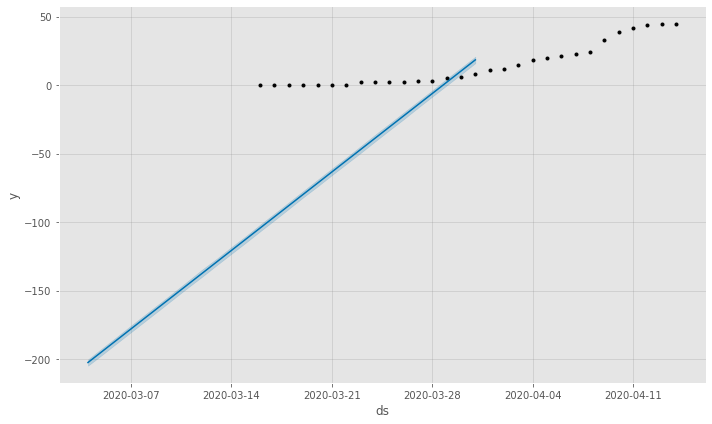

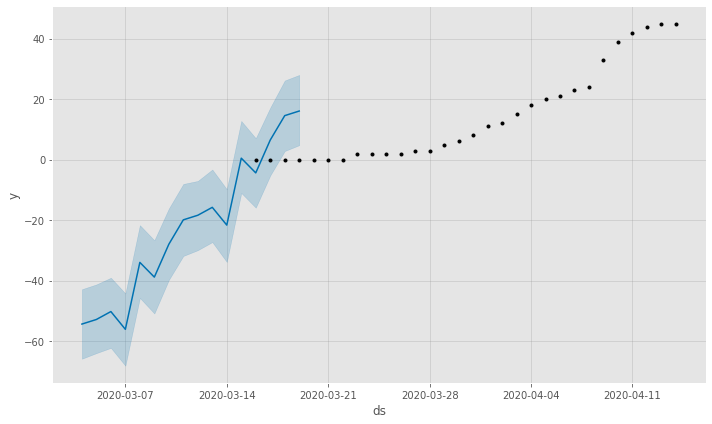

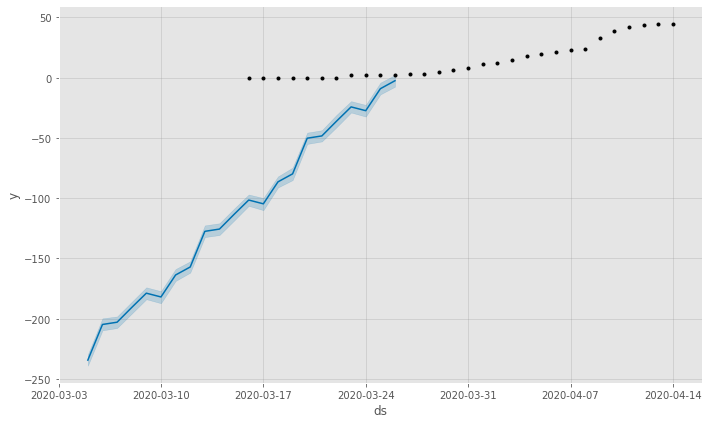

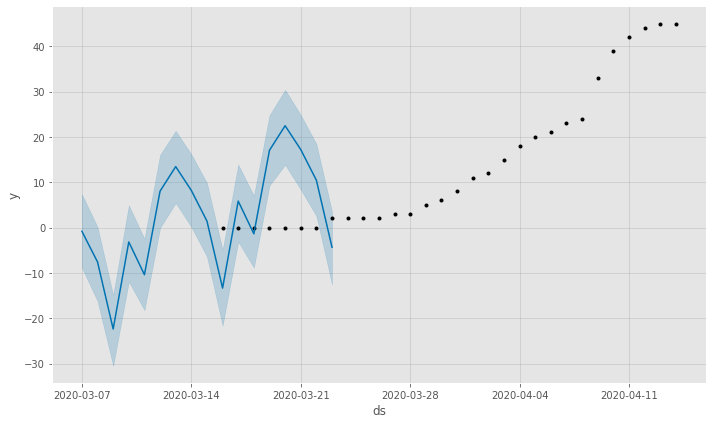

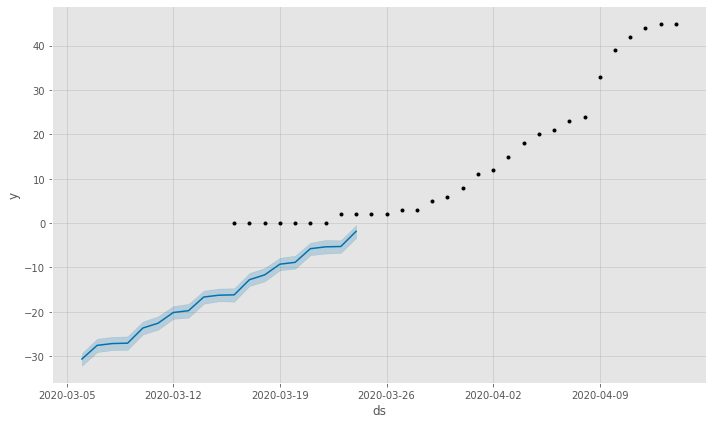

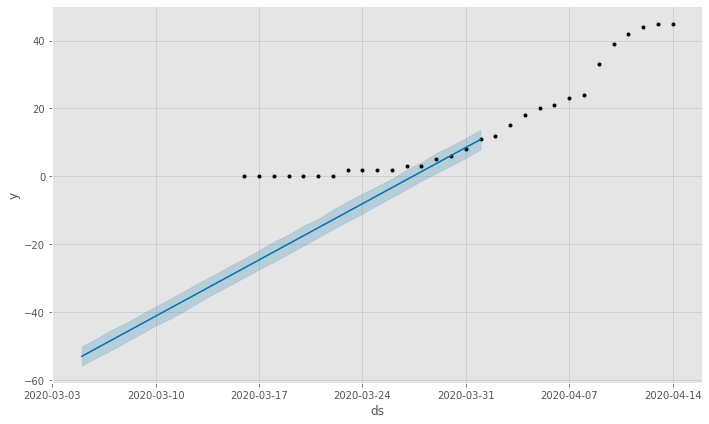

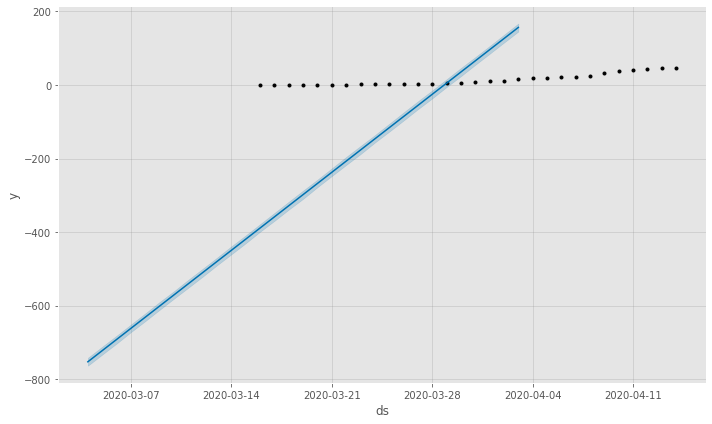

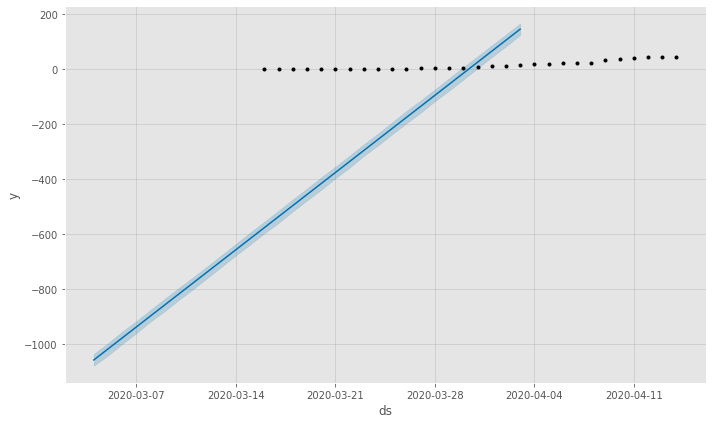

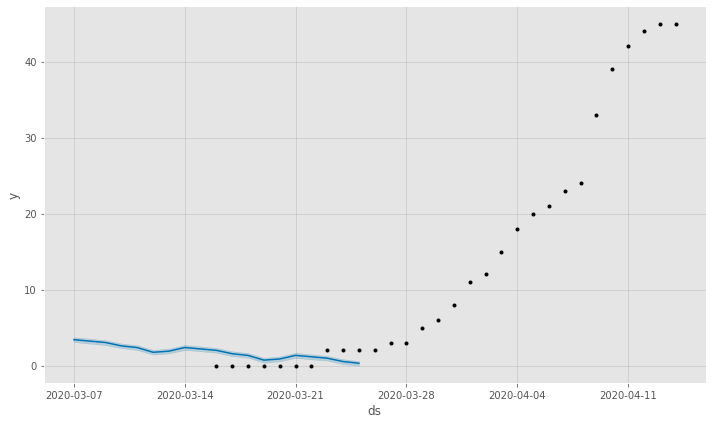

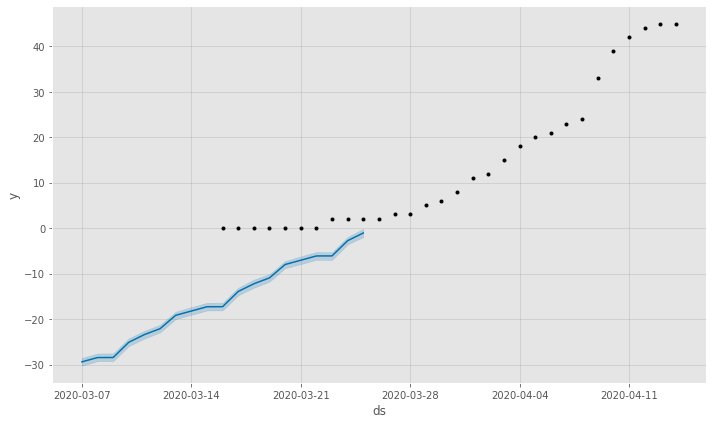

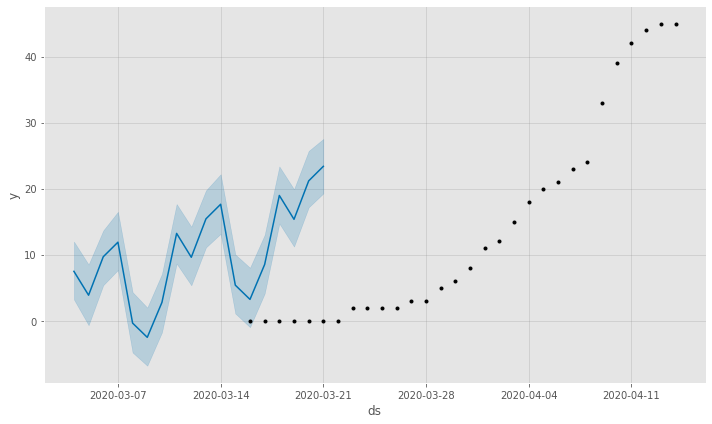

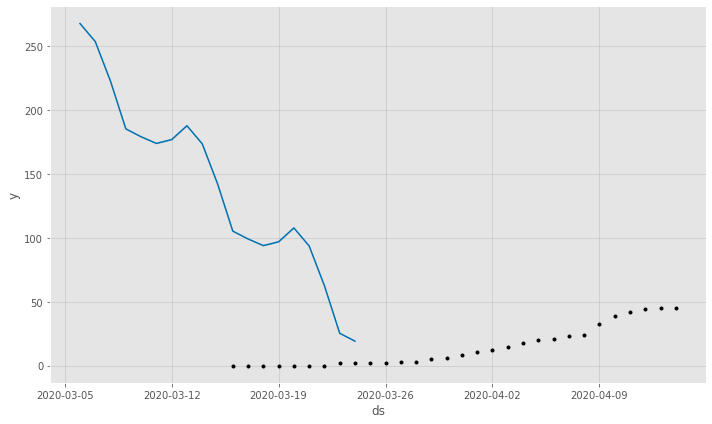

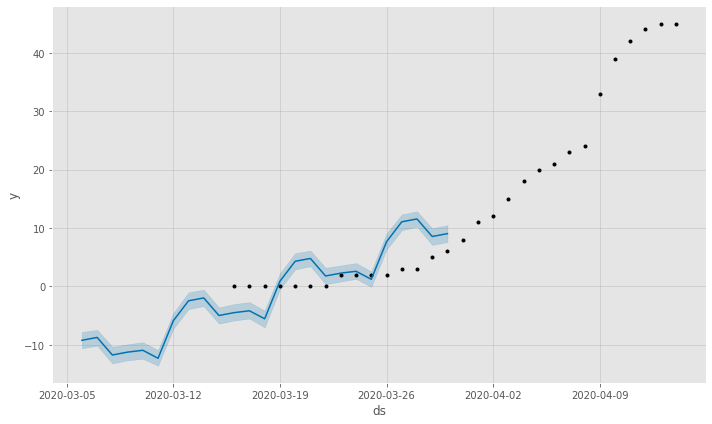

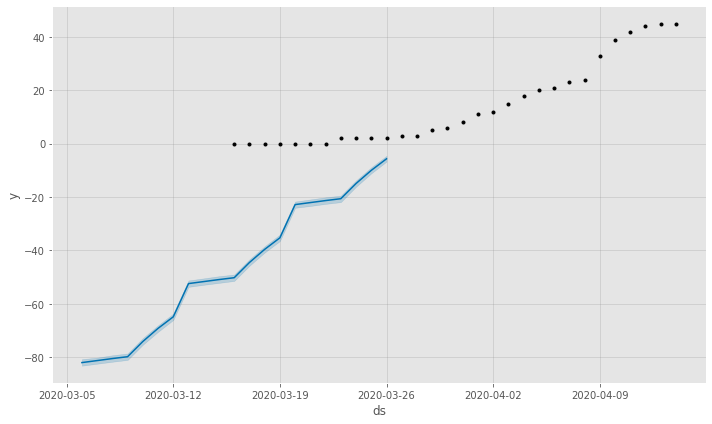

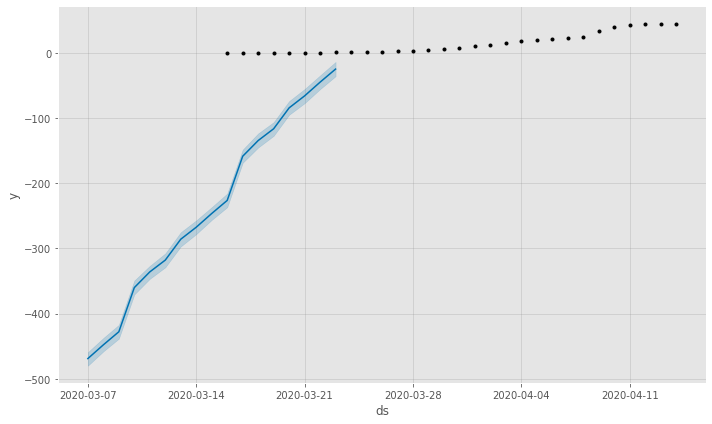

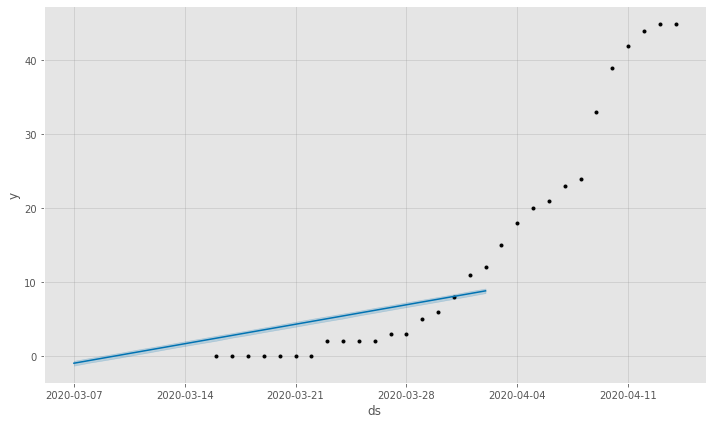

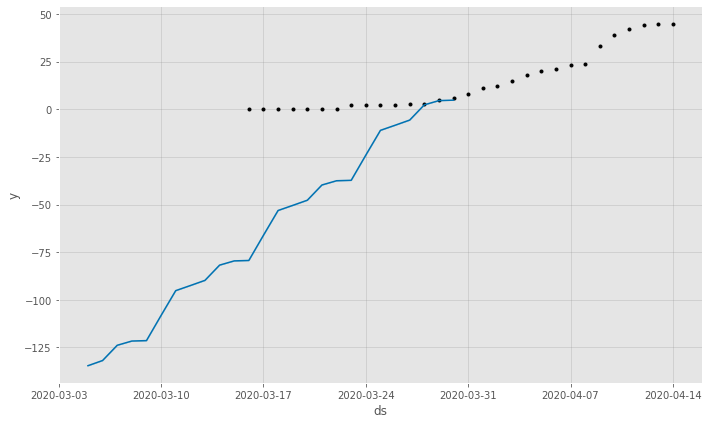

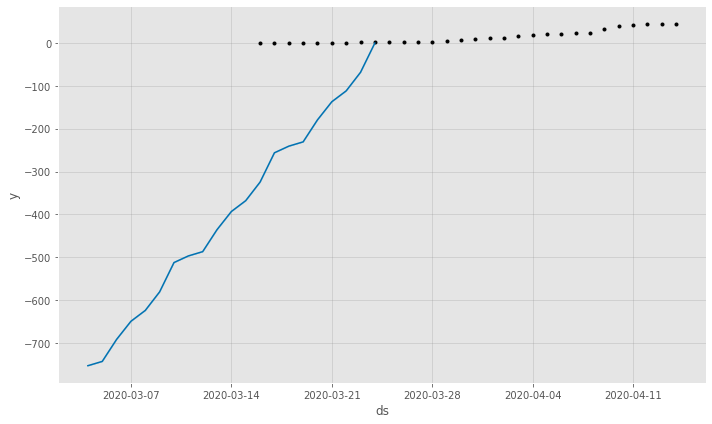

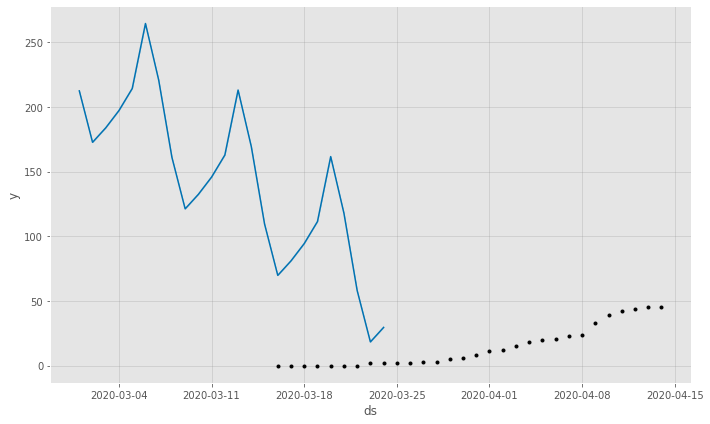

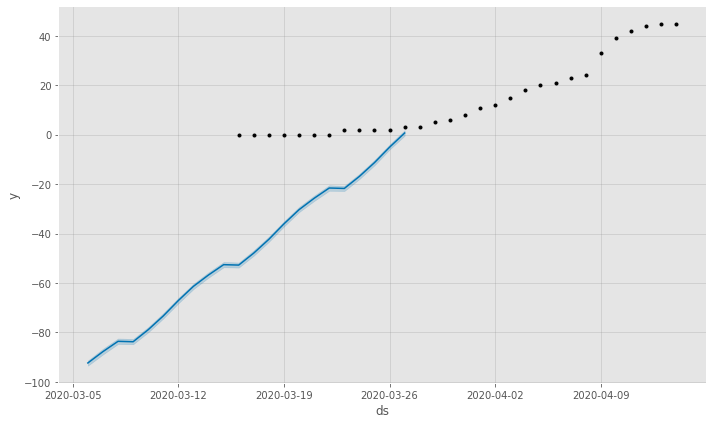

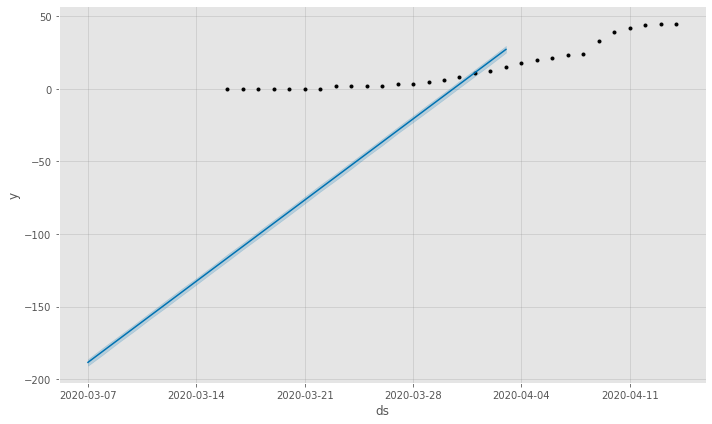

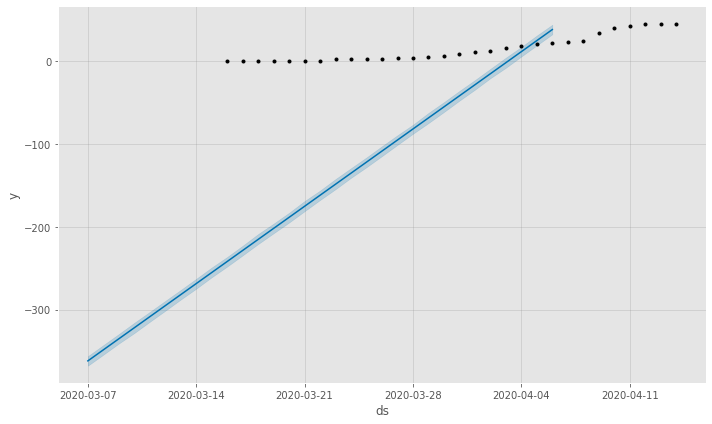

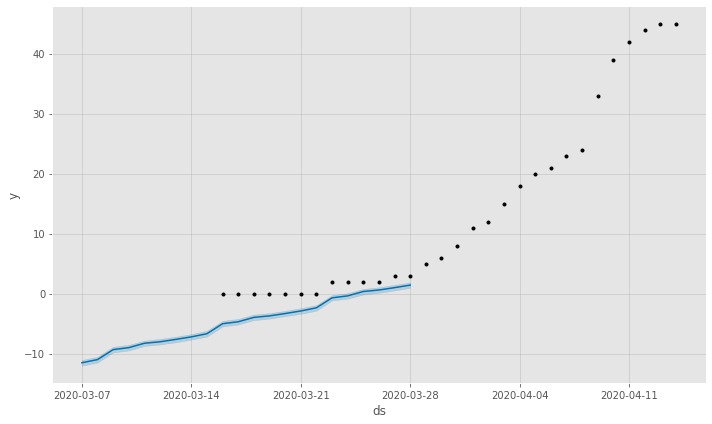

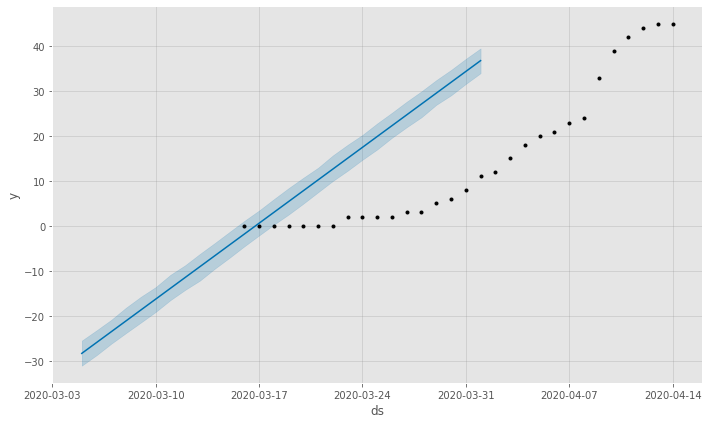

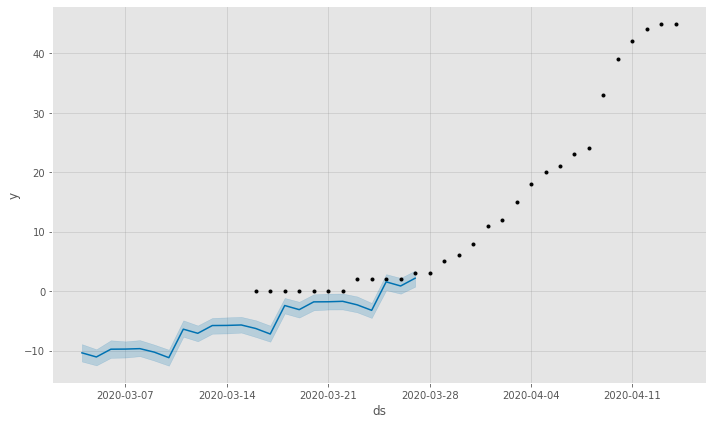

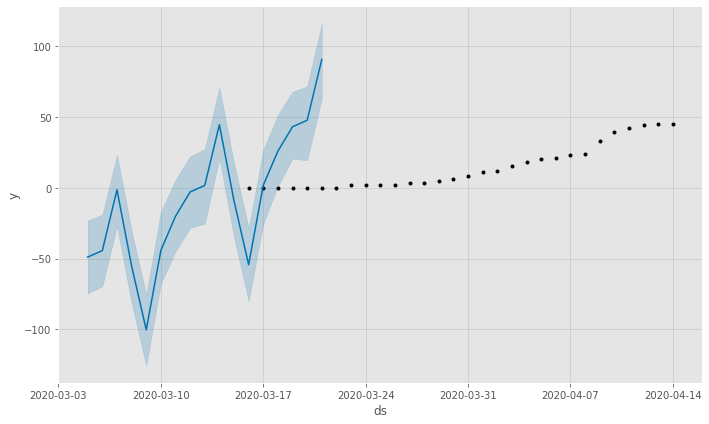

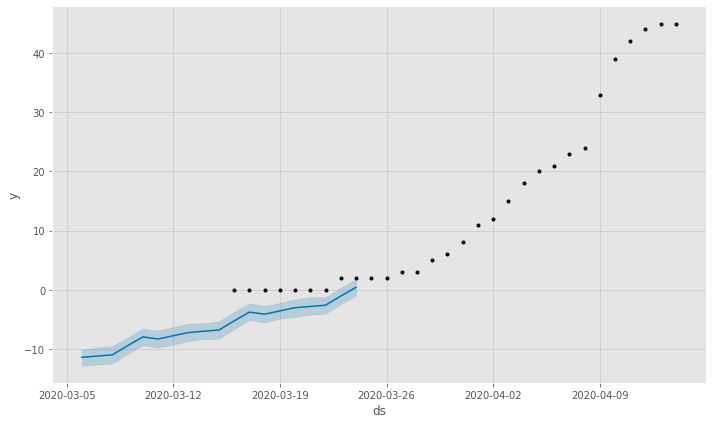

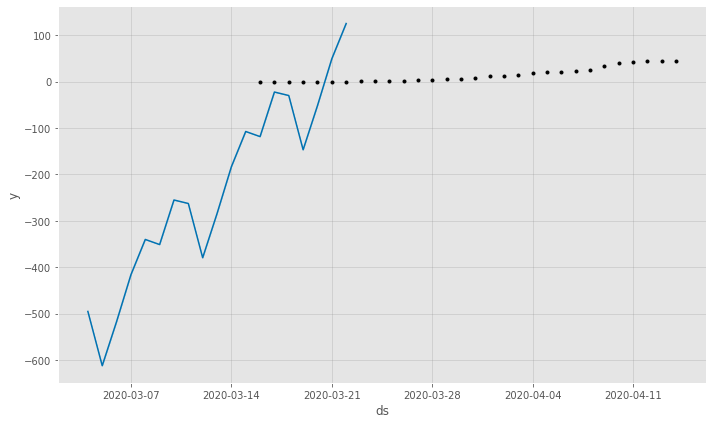

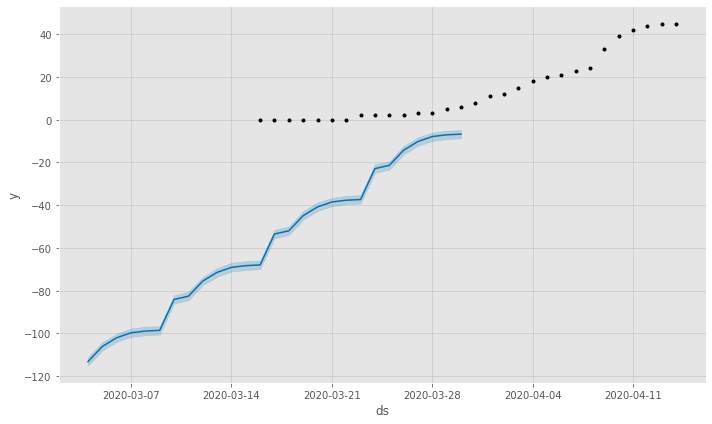

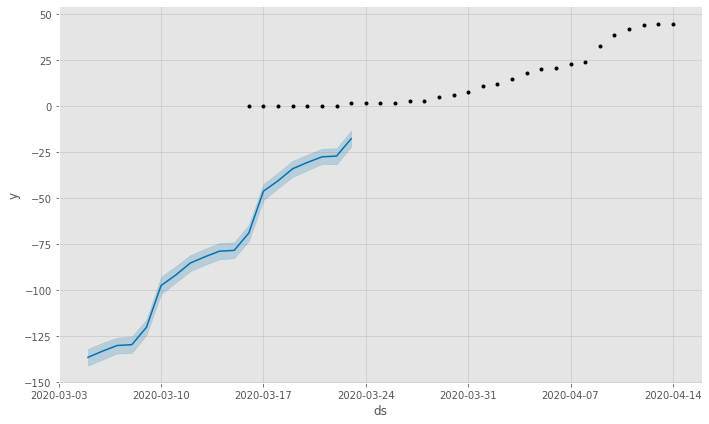

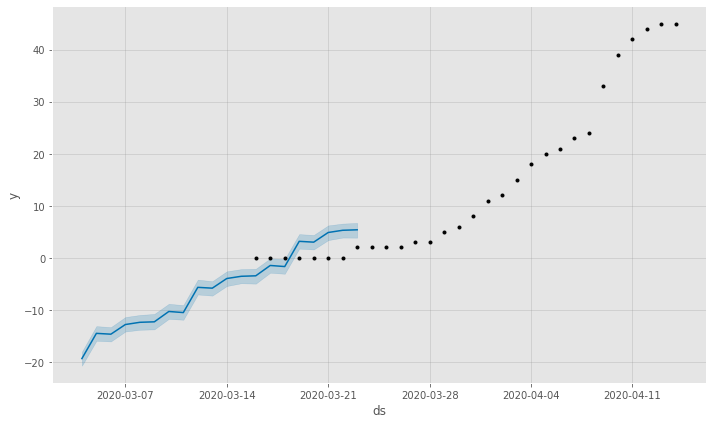

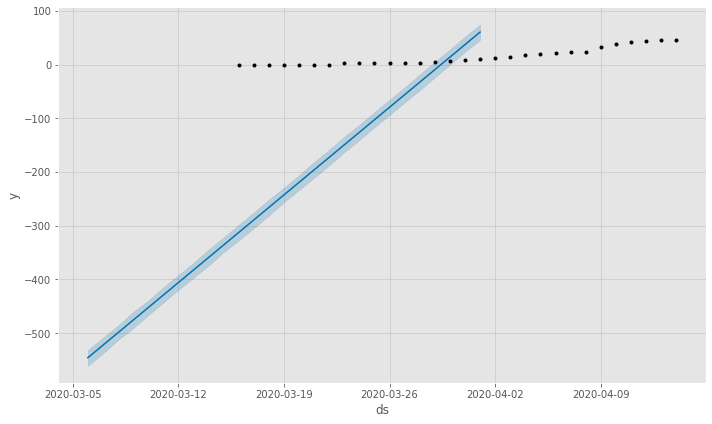

In [33]:
for i in range(len(SAH_data)):
    prophet_model.plot(predictions[i])

C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
C:\Users\camco\Anaconda3\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

IndexError: list index out of range

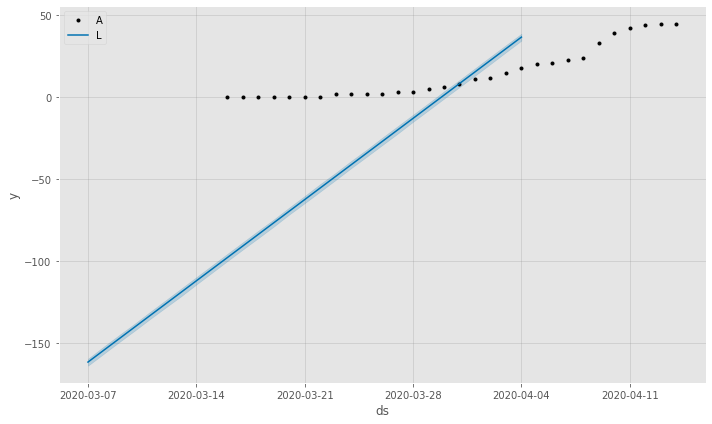

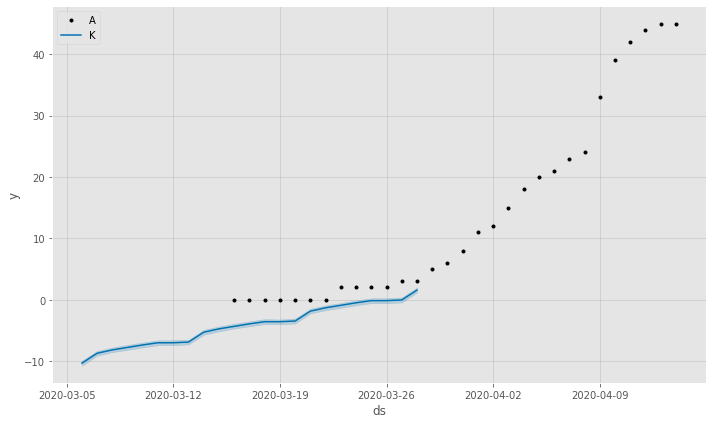

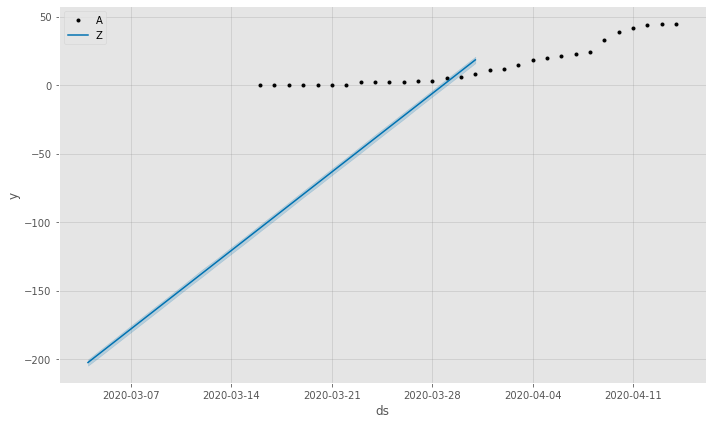

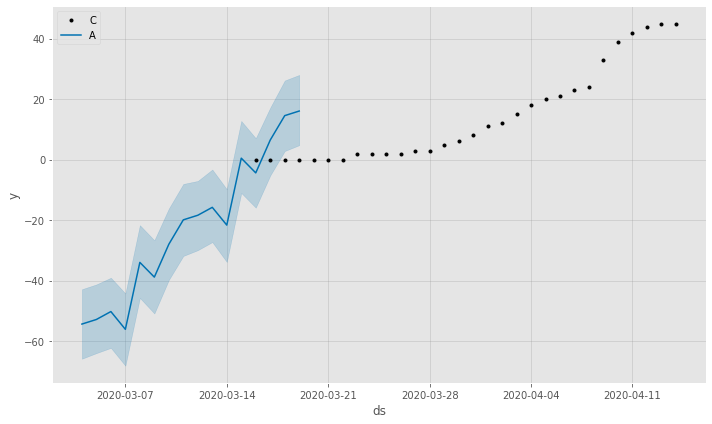

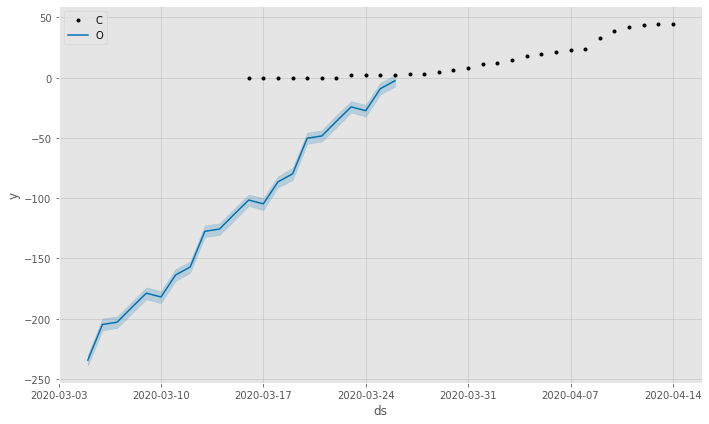

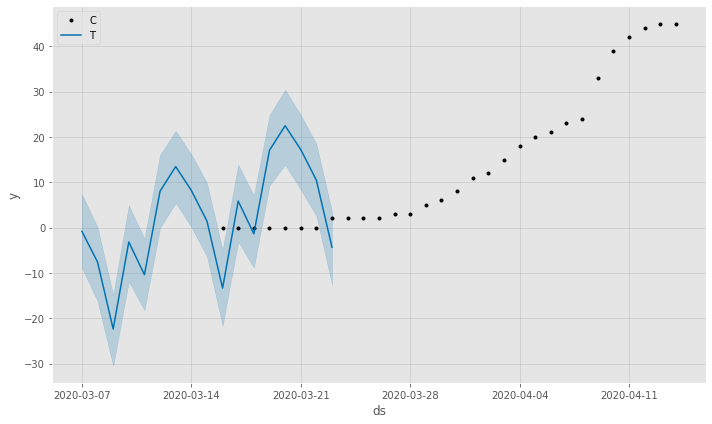

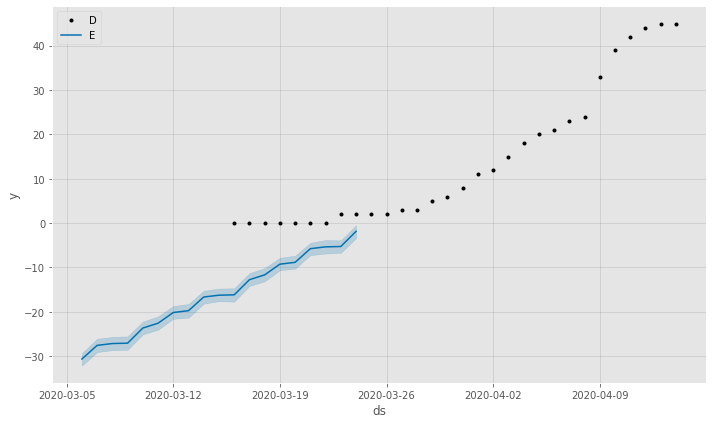

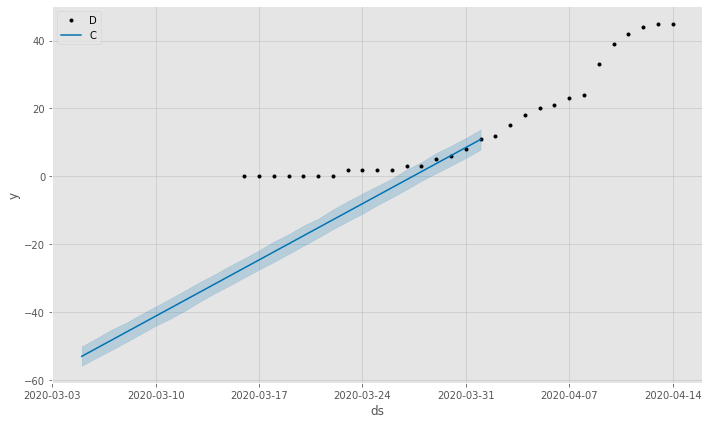

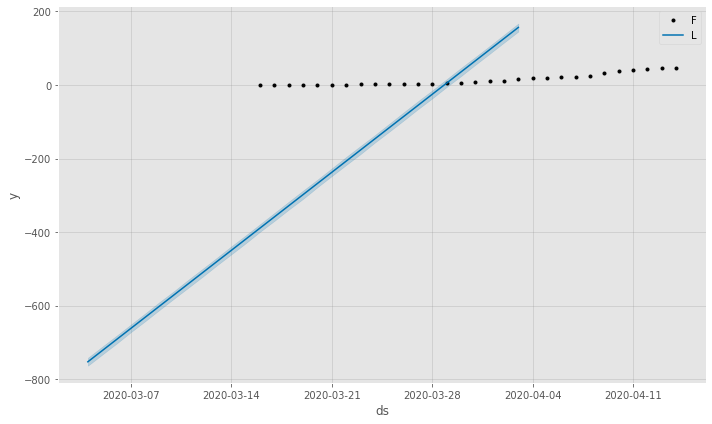

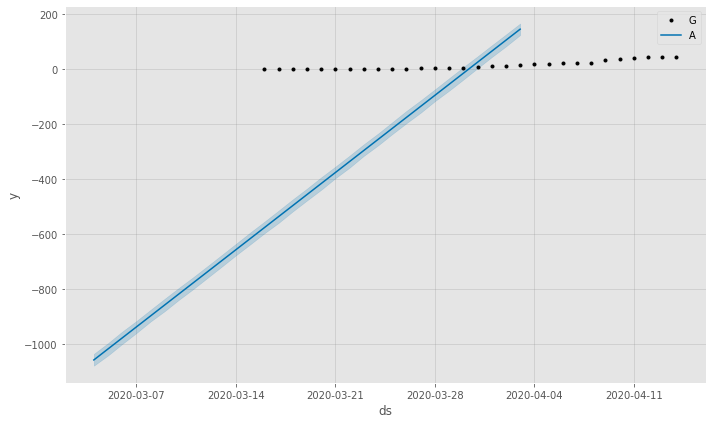

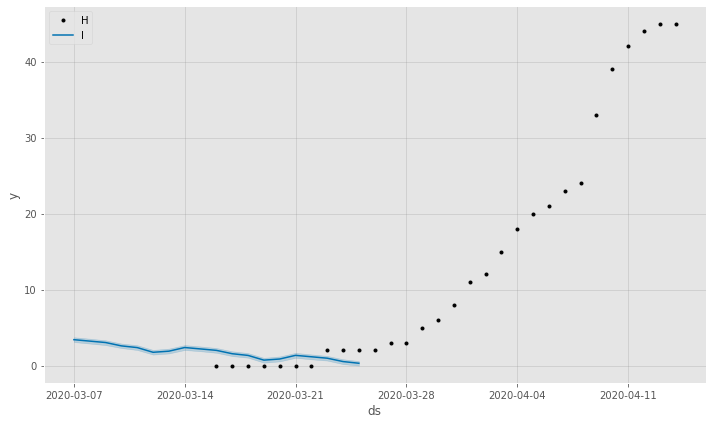

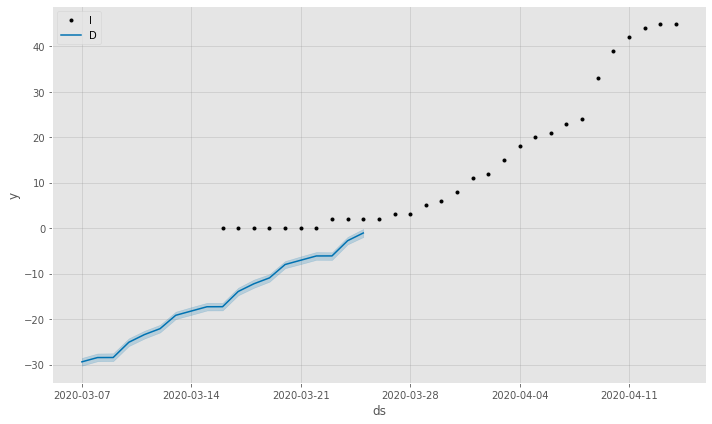

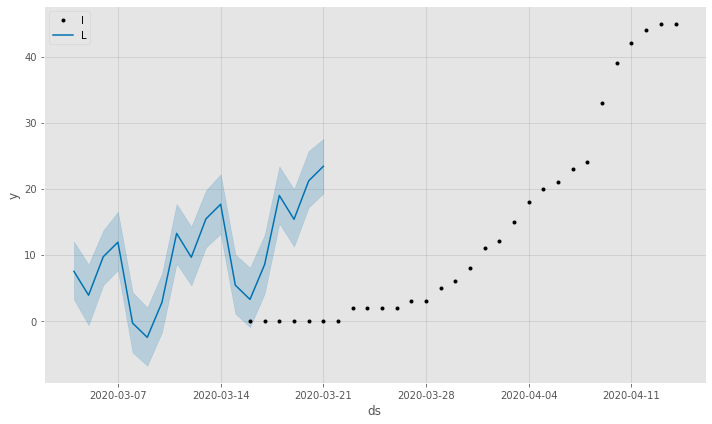

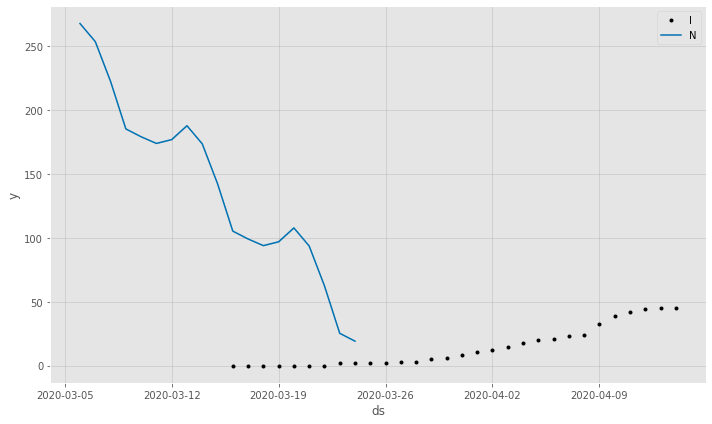

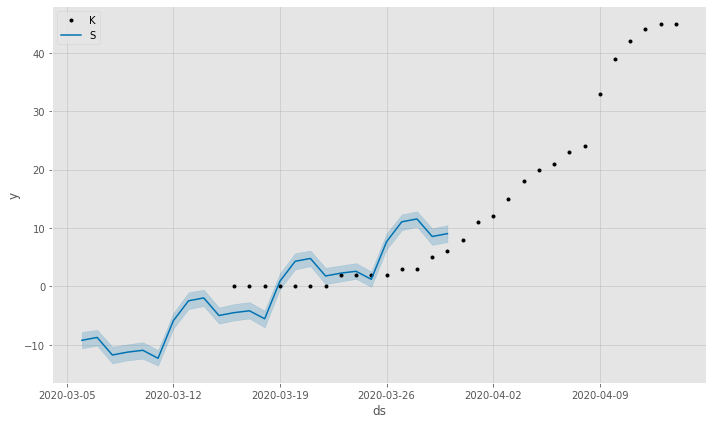

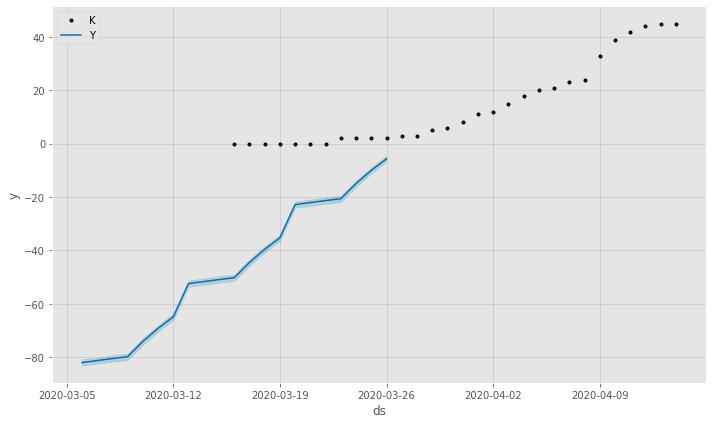

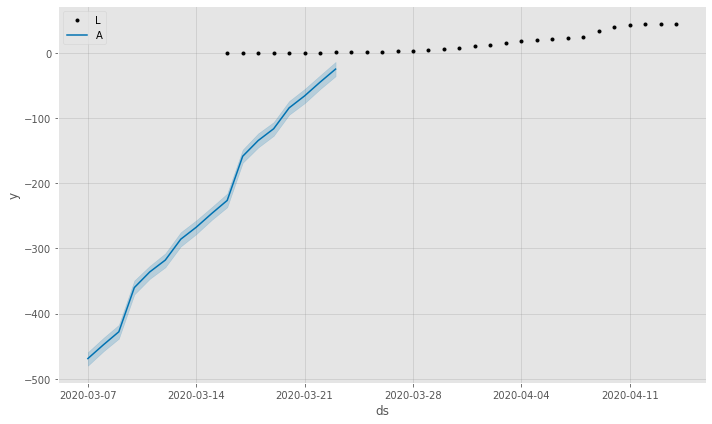

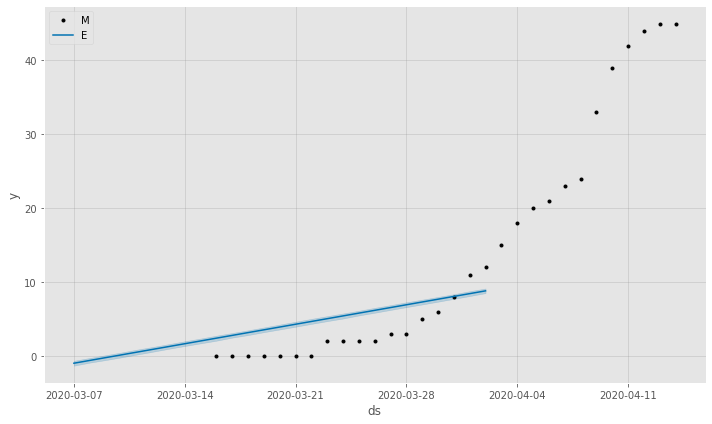

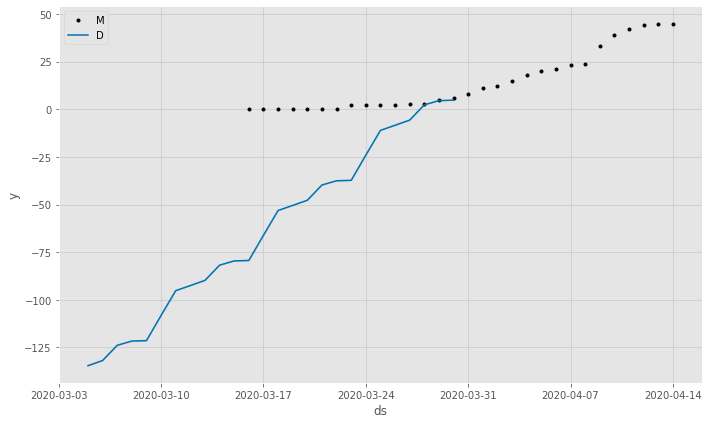

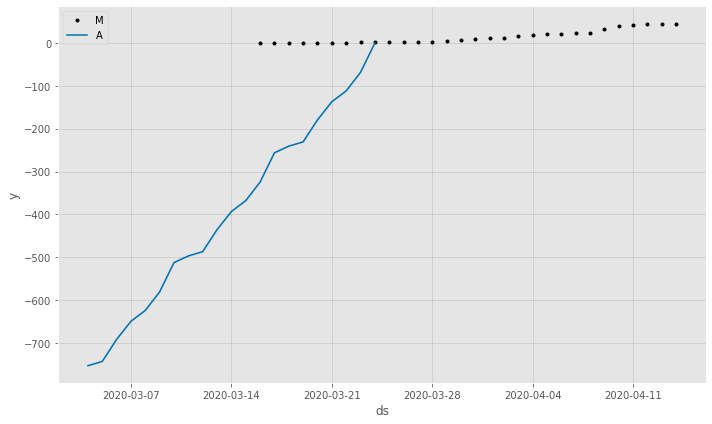

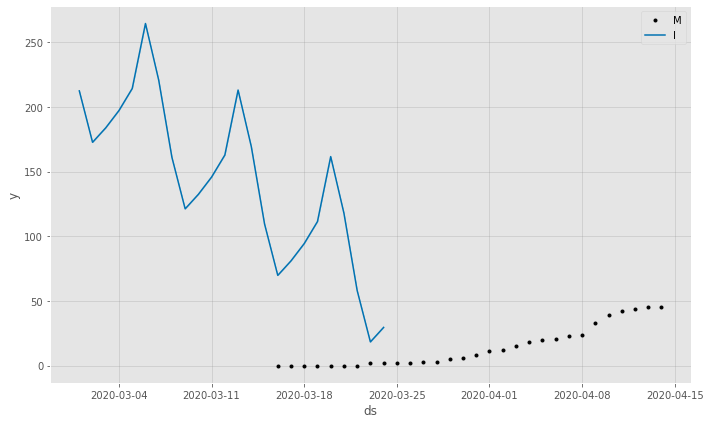

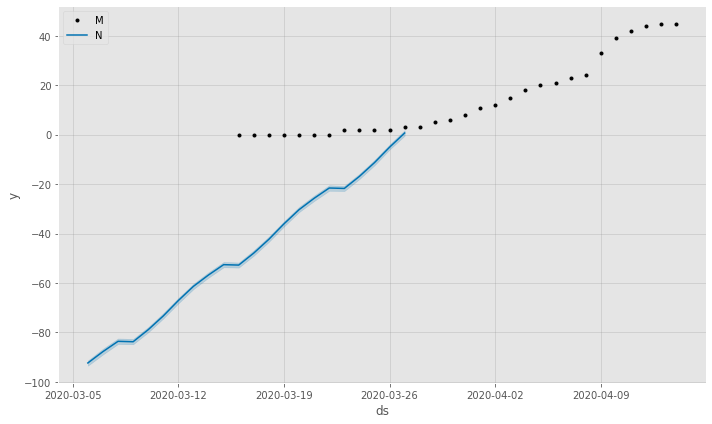

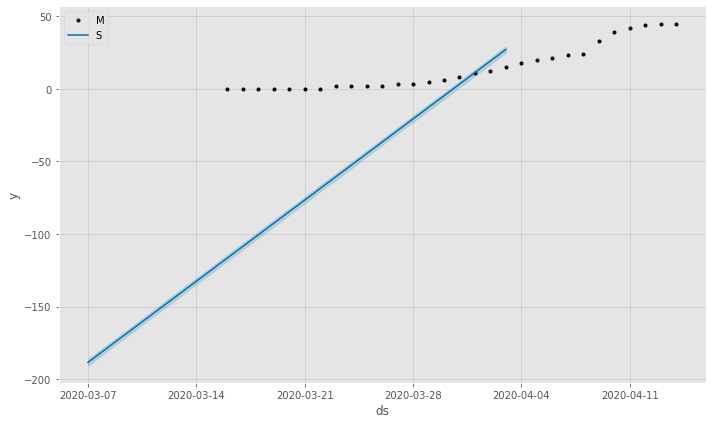

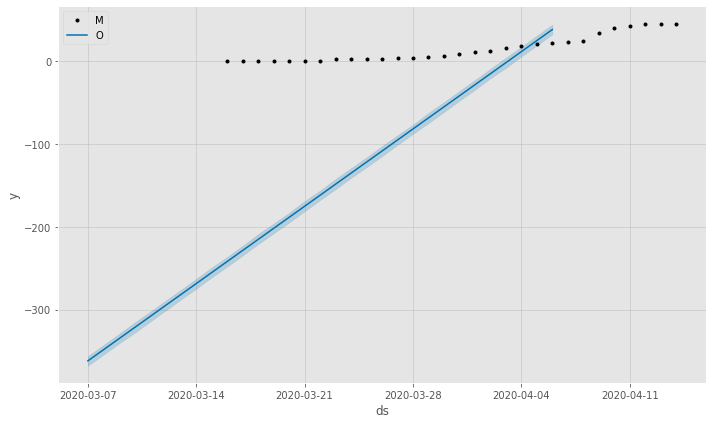

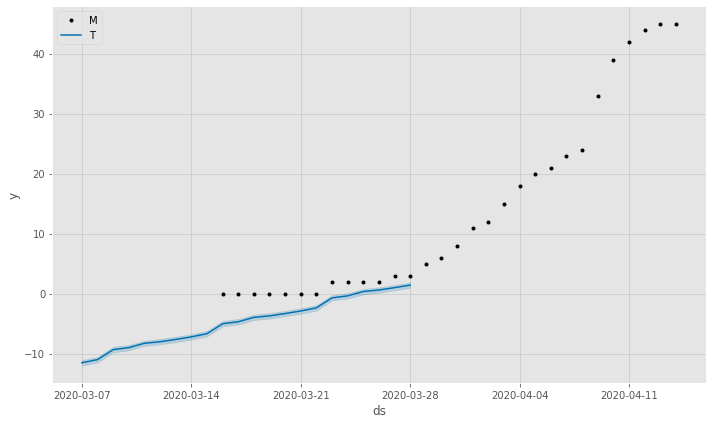

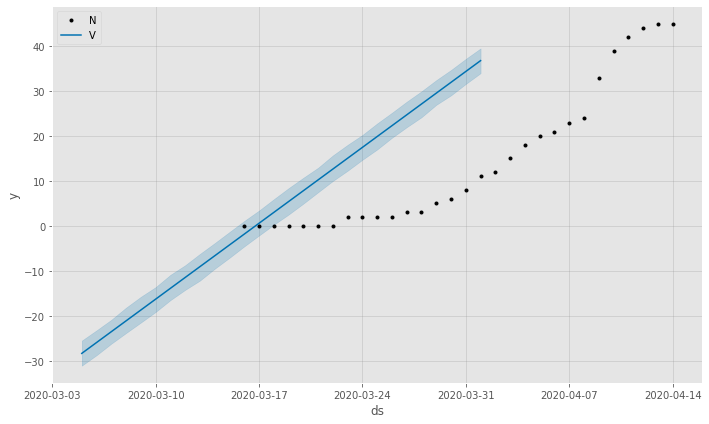

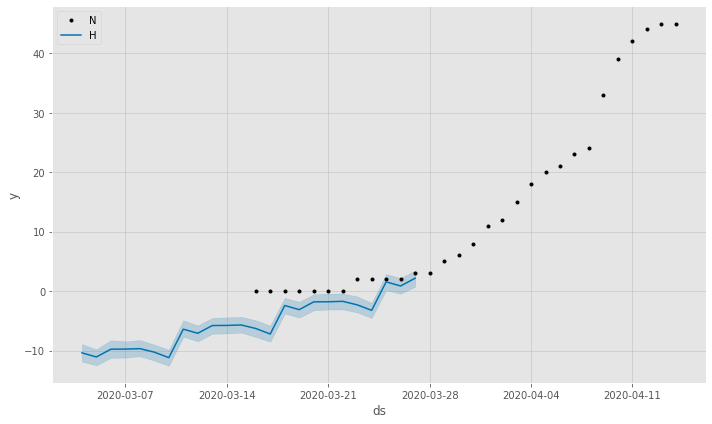

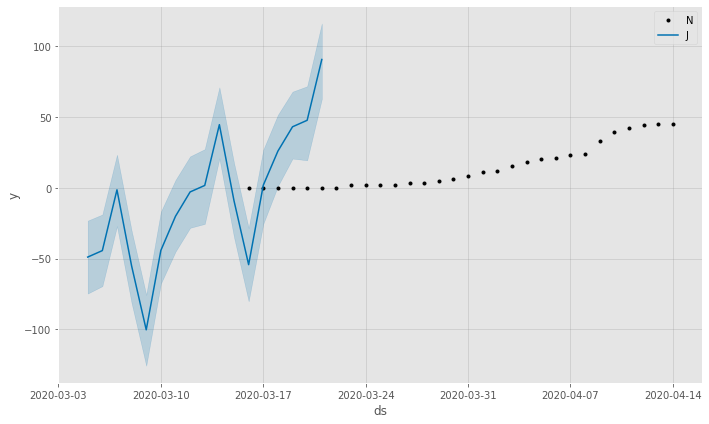

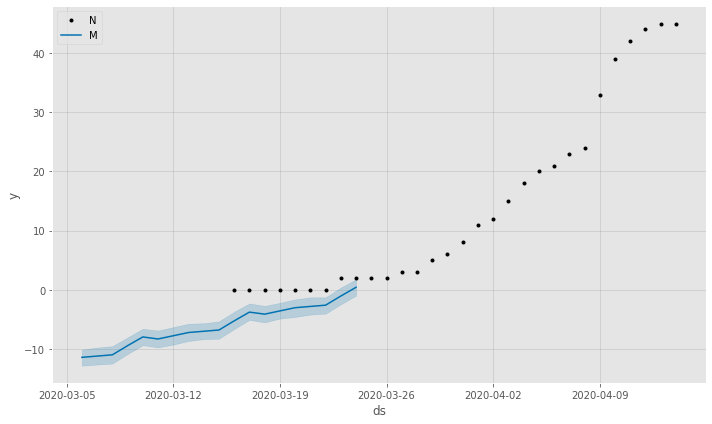

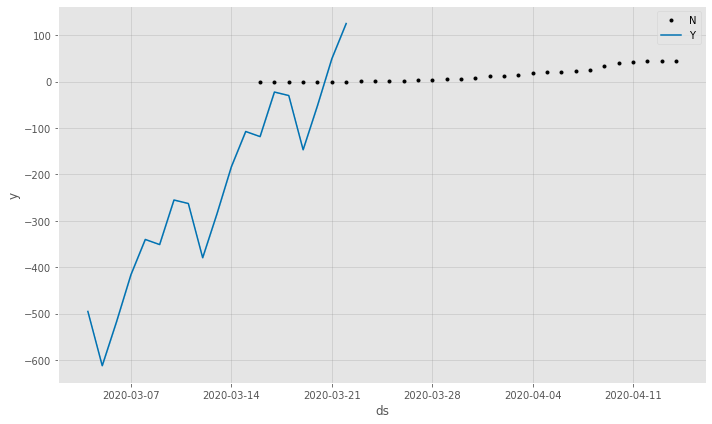

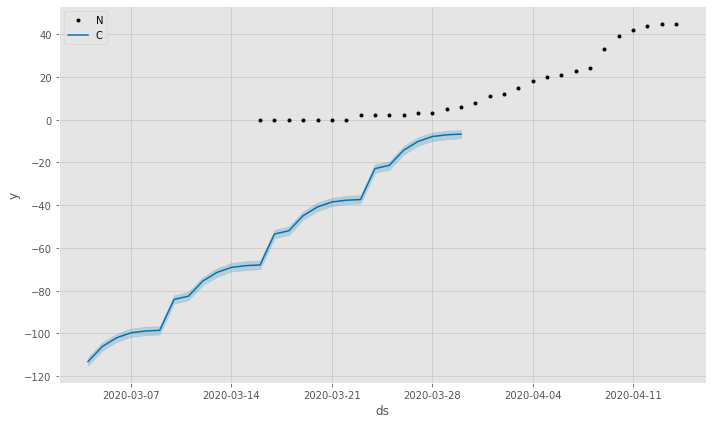

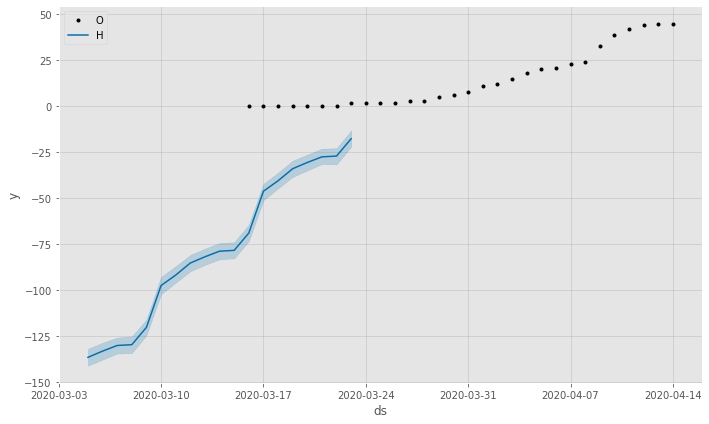

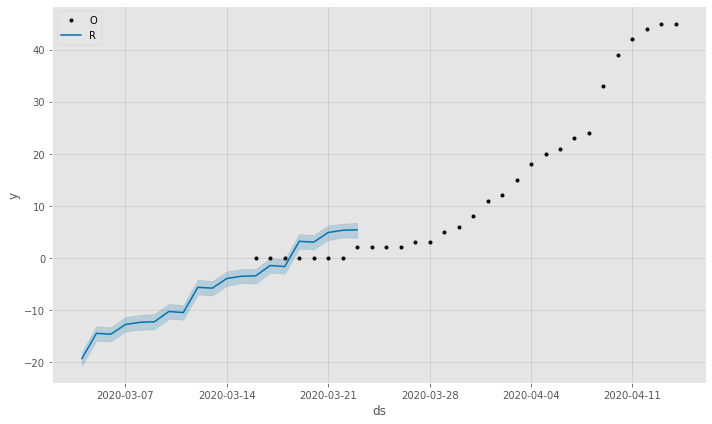

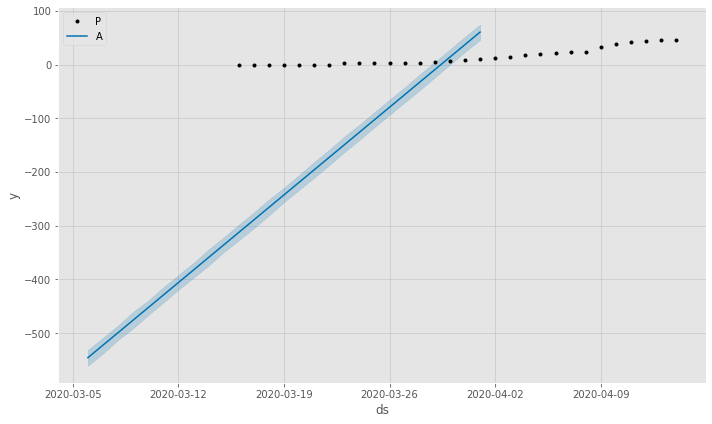

In [37]:
# Plot parameters
index = 0
states_used = []
fig_rows = math.ceil((len(SAH_data) / 5))

# Plots
for i in range(len(SAH_data)):
    prophet_model.plot(predictions[index])
    name = SAH_data['state'][index]
    plt.legend(name)
    states_used.append(name)
    if index == (len(SAH_data)-1):
        break
    else:
        index = index + 1